# Dataset personal

## 1. Importar librerías necesarias

In [12]:
!pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 847.4 kB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 9.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 3.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 2.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 929.3 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import glob
from PIL import Image
import shutil
import fiftyone as fo
import fiftyone.utils.yolo as fouy
import matplotlib.pyplot as plt
import glob
import shutil
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import cv2
import numpy as np
from tqdm import tqdm

# 2. Estandarizar archivos

## 2.1. Estandarizar tipos

In [45]:
# Ruta de la carpeta del dataset
dataset_folder = './Data/Dataset'

# Extensiones de archivos de imágenes a convertir
image_extensions = ['*.png', '*.jpeg']

# Convertir imágenes a jpg
for ext in image_extensions:
    for image_path in glob.glob(os.path.join(dataset_folder, ext)):
        # Abrir la imagen
        with Image.open(image_path) as img:
            # Convertir la imagen a modo RGB si no lo está
            img = img.convert('RGB')
            
            # Definir la nueva ruta con la extensión .jpg
            new_image_path = os.path.splitext(image_path)[0] + '.jpg'
            
            # Guardar la imagen en formato jpg
            img.save(new_image_path, 'JPEG')
            
            # Eliminar el archivo original
            os.remove(image_path)

print("Conversión completada.")

Conversión completada.


## 2.3. Estandarizar Nombres

In [46]:
# Ruta de la carpeta del dataset
dataset_folder = './Data/Dataset'

# Listas de archivos
image_files = glob.glob(os.path.join(dataset_folder, '*.jpg'))
txt_files = glob.glob(os.path.join(dataset_folder, '*.txt'))

# Función para obtener el nombre base del archivo
def get_base_name(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# Diccionarios para emparejar archivos
image_dict = {get_base_name(f): f for f in image_files}
txt_dict = {get_base_name(f): f for f in txt_files}

# Emparejar y renombrar archivos
counter = 1
for base_name in sorted(set(image_dict.keys()).union(set(txt_dict.keys()))):
    while True:
        new_name = f'{counter:04d}'
        
        new_image_path = os.path.join(dataset_folder, new_name + '.jpg')
        new_txt_path = os.path.join(dataset_folder, new_name + '.txt')
        
        # Verificar si ya existen archivos con el nuevo nombre
        if os.path.exists(new_image_path) or os.path.exists(new_txt_path):
            counter += 1
        else:
            break
    
    image_path = image_dict.get(base_name)
    txt_path = txt_dict.get(base_name)
    
    if image_path and txt_path:
        # Ambos archivos existen, renombrar ambos
        os.rename(image_path, new_image_path)
        os.rename(txt_path, new_txt_path)
        
        counter += 1
    elif image_path:
        # Solo existe la imagen, no renombrar
        pass
    elif txt_path:
        # Solo existe el archivo de texto, no renombrar
        pass

print("Renombrado completado.")

Renombrado completado.


### Mover datos desaparejados a la carpeta de error de etiquetado

In [47]:
# Rutas de las carpetas
dataset_folder = './Data/Dataset'
error_folder = './Data/label_errors'

# Crear la carpeta de errores si no existe
os.makedirs(error_folder, exist_ok=True)

# Listas de archivos
image_files = glob.glob(os.path.join(dataset_folder, '*.jpg'))
txt_files = glob.glob(os.path.join(dataset_folder, '*.txt'))

# Función para obtener el nombre base del archivo (sin extensión)
def get_base_name(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# Diccionarios para emparejar archivos
image_dict = {get_base_name(f): f for f in image_files}
txt_dict = {get_base_name(f): f for f in txt_files}

# Verificar archivos no emparejados
unmatched_images = set(image_dict.keys()) - set(txt_dict.keys())
unmatched_txts = set(txt_dict.keys()) - set(image_dict.keys())

# Mover archivos no emparejados a la carpeta de errores e imprimir sus nombres
print("Archivos movidos a label_errors:")
for base_name in unmatched_images:
    src = image_dict[base_name]
    dst = os.path.join(error_folder, os.path.basename(src))
    shutil.move(src, dst)
    print(f"Imagen sin pareja: {os.path.basename(src)}")

for base_name in unmatched_txts:
    src = txt_dict[base_name]
    dst = os.path.join(error_folder, os.path.basename(src))
    shutil.move(src, dst)
    print(f"Archivo de texto sin pareja: {os.path.basename(src)}")

print("Verificación y movimiento de archivos completado.")

Archivos movidos a label_errors:
Imagen sin pareja: d.jpg
Imagen sin pareja: gravifiorino_2.jpg
Archivo de texto sin pareja: classes.txt
Archivo de texto sin pareja: gravifiorino_3.txt
Verificación y movimiento de archivos completado.


## 2.4. Estandarización de notación a YOLOv5

### Explorar formato de anotación de nueve elementos

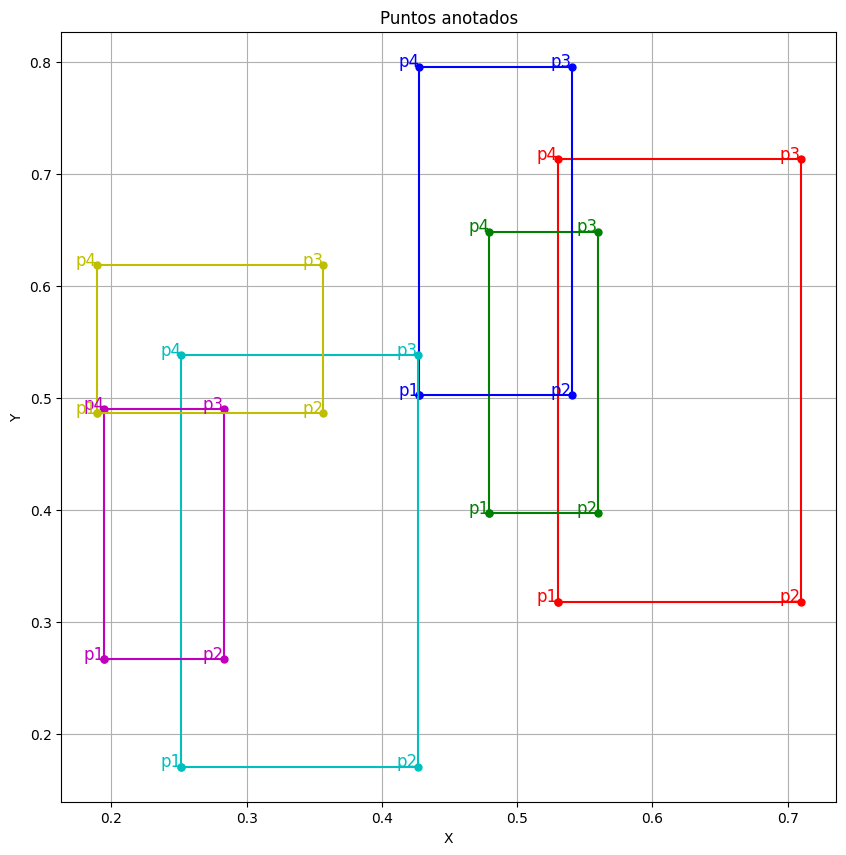

In [48]:
# Función para leer el archivo .txt y extraer los datos
def leer_anotaciones(file_path):
    anotaciones = []
    with open(file_path, 'r') as file:
        for line in file:
            partes = line.strip().split()
            clase = int(partes[0])
            puntos = [float(x) for x in partes[1:]]
            anotaciones.append((clase, puntos))
    return anotaciones

# Función para graficar los puntos
def graficar_anotaciones(anotaciones):
    colores = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple']
    
    plt.figure(figsize=(10, 10))
    
    for i, (clase, puntos) in enumerate(anotaciones):
        x = puntos[0::2]
        y = puntos[1::2]
        color = colores[i % len(colores)]
        
        plt.plot(x + [x[0]], y + [y[0]], color=color, marker='o', linestyle='-', markersize=5)
        
        for j in range(len(x)):
            plt.text(x[j], y[j], f'p{j+1}', fontsize=12, color=color, ha='right')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Puntos anotados')
    plt.grid(True)
    plt.show()

# Ruta del archivo .txt
file_path = 'Data/Dataset/0032.txt'

# Leer anotaciones y graficar
anotaciones = leer_anotaciones(file_path)
graficar_anotaciones(anotaciones)

In [49]:
# Rutas de las carpetas
dataset_folder = './Data/Dataset'
error_folder = './Data/label_errors'

# Crear la carpeta de errores si no existe
if not os.path.exists(error_folder):
    os.makedirs(error_folder)

# Listas de archivos
image_files = glob.glob(os.path.join(dataset_folder, '*.jpg'))
txt_files = glob.glob(os.path.join(dataset_folder, '*.txt'))

# Función para obtener el nombre base del archivo (sin extensión)
def get_base_name(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# Diccionarios para emparejar archivos
image_dict = {get_base_name(f): f for f in image_files}
txt_dict = {get_base_name(f): f for f in txt_files}

# Función para verificar si los valores están normalizados
def is_normalized(value):
    return 0 <= value <= 1

# Función para convertir las anotaciones
def convert_annotations(txt_path, width, height):
    lines = []
    has_error = False
    with open(txt_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 9:
                class_id = parts[0]
                x1, y1 = float(parts[1]), float(parts[2])
                x2, y2 = float(parts[3]), float(parts[4])
                x3, y3 = float(parts[5]), float(parts[6])
                x4, y4 = float(parts[7]), float(parts[8])
                
                # Verificar si los valores están normalizados
                if all(is_normalized(val) for val in [x1, y1, x2, y2, x3, y3, x4, y4]):
                    # Los valores están normalizados, calcular el centro y tamaño directamente
                    x_center = (x3 + x4) / 2
                    y_center = (y1 + y4) / 2
                    box_width = abs(x4 - x3)
                    box_height = abs(y4 - y1)
                else:
                    # Los valores no están noramalizados, convertir y después normalizar
                    x_center = ((x3 - x4) / 2.0 + x4) / width
                    y_center = ((y4 - y1) / 2.0 + y1) / height
                    box_width = abs(x4 - x3) / width
                    box_height = abs(y4 - y1) / height
                
                lines.append(f'{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}')
            elif len(parts) == 5:
                # Verificar normalización en el formato de 5 elementos
                class_id, x_center, y_center, box_width, box_height = parts
                if all(is_normalized(float(val)) for val in [x_center, y_center, box_width, box_height]):
                    lines.append(line.strip())  # Keep existing normalized line
                else:
                    # Normalizar si no lo están
                    x_center, y_center = float(x_center) / width, float(y_center) / height
                    box_width, box_height = float(box_width) / width, float(box_height) / height
                    lines.append(f'{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}')
            else:
                has_error = True
                break
    
    return lines, has_error

# Convertir anotaciones de todos los archivos
for base_name in sorted(set(image_dict.keys()).union(set(txt_dict.keys()))):
    image_path = image_dict.get(base_name)
    txt_path = txt_dict.get(base_name)
    
    if image_path and txt_path:
        # Obtener las dimensiones de la imagen
        with Image.open(image_path) as img:
            width, height = img.size
        
        # Convertir las anotaciones
        lines, has_error = convert_annotations(txt_path, width, height)
        
        if has_error:
            # Mover el archivo con error al directorio de errores
            shutil.move(txt_path, os.path.join(error_folder, os.path.basename(txt_path)))
            shutil.move(image_path, os.path.join(error_folder, os.path.basename(image_path)))
            print(f"Archivo movido a errores: {base_name}")
        else:
            with open(txt_path, 'w') as file:
                file.write('\n'.join(lines))  # Join lines without extra newlines

print("Conversión de anotaciones completada. Archivos con errores movidos a './Data/label_errors'.")

Archivo movido a errores: 0232
Archivo movido a errores: 0428
Archivo movido a errores: 0497
Archivo movido a errores: 0500
Archivo movido a errores: 0503
Archivo movido a errores: 0513
Archivo movido a errores: 0514
Archivo movido a errores: 0517
Archivo movido a errores: 0524
Archivo movido a errores: 0675
Archivo movido a errores: 0676
Archivo movido a errores: 0678
Archivo movido a errores: 0679
Archivo movido a errores: 0680
Archivo movido a errores: 0681
Archivo movido a errores: 0683
Archivo movido a errores: 0684
Archivo movido a errores: 0685
Archivo movido a errores: 0688
Archivo movido a errores: 1289
Archivo movido a errores: 1291
Archivo movido a errores: 1300
Conversión de anotaciones completada. Archivos con errores movidos a './Data/label_errors'.


# 3. Validación del Dataset

## 3.1. Verificar que no haya clases incorrectas ni valores negativos

In [50]:
# Rutas de las carpetas
dataset_folder = './Data/Dataset'
error_folder = './Data/label_errors'

# Crear la carpeta de errores si no existe
if not os.path.exists(error_folder):
    os.makedirs(error_folder)

# Listas de archivos
txt_files = glob.glob(os.path.join(dataset_folder, '*.txt'))
image_files = glob.glob(os.path.join(dataset_folder, '*.jpg'))

# Función para verificar y limpiar las anotaciones
def check_and_clean_annotations(txt_path):
    cleaned_lines = []
    with open(txt_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            values = list(map(float, parts[1:]))
            
            if not (0 <= class_id <= 48):
                print(f"Clase fuera del intervalo en archivo {txt_path}: {line.strip()}")
                continue
            
            if any(value < 0 for value in values):
                print(f"Valores negativos en archivo {txt_path}: {line.strip()}")
                continue
            
            cleaned_lines.append(line)
    
    if not cleaned_lines:
        # Si no quedan líneas, mover el archivo a la carpeta de errores
        image_path = txt_path.replace('.txt', '.jpg')
        shutil.move(txt_path, os.path.join(error_folder, os.path.basename(txt_path)))
        if os.path.exists(image_path):
            shutil.move(image_path, os.path.join(error_folder, os.path.basename(image_path)))
        print(f"Archivo movido a errores: {txt_path}")
    else:
        with open(txt_path, 'w') as file:
            file.write(''.join(cleaned_lines))

# Verificar y limpiar anotaciones de todos los archivos
for txt_path in txt_files:
    check_and_clean_annotations(txt_path)

print("Verificación y limpieza de anotaciones completada.")



Clase fuera del intervalo en archivo ./Data/Dataset\0132.txt: 49 0.502445 0.666554 0.193173 0.057588
Clase fuera del intervalo en archivo ./Data/Dataset\0277.txt: 49 0.382127 0.370249 0.230263 0.236355
Clase fuera del intervalo en archivo ./Data/Dataset\0662.txt: 49 0.695690 0.502299 0.195690 0.275862
Clase fuera del intervalo en archivo ./Data/Dataset\0849.txt: 49 0.724638 0.505020 0.224638 0.056888
Valores negativos en archivo ./Data/Dataset\1003.txt: 24 0.000141 0.000246 -0.000046 0.000103
Valores negativos en archivo ./Data/Dataset\1003.txt: 11 0.000196 0.000129 -0.000042 0.000109
Valores negativos en archivo ./Data/Dataset\1007.txt: 9 0.000094 0.000164 -0.000054 0.000073
Valores negativos en archivo ./Data/Dataset\1007.txt: 5 0.000095 0.000162 -0.000051 0.000073
Valores negativos en archivo ./Data/Dataset\1009.txt: 19 0.000172 0.000004 -0.000052 -0.000009
Valores negativos en archivo ./Data/Dataset\1011.txt: 18 0.000181 0.000209 -0.000086 0.000066
Valores negativos en archivo ./Da

## 3.2. Verificar que los bounding boxes no excedan los límites de la imagen

In [51]:
import os
import glob
import shutil
from PIL import Image

# Rutas de las carpetas
dataset_folder = './Data/Dataset'
label_errors_folder = './Data/label_errors'

# Crear la carpeta de errores de etiqueta si no existe
if not os.path.exists(label_errors_folder):
    os.makedirs(label_errors_folder)

# Listas de archivos
image_files = glob.glob(os.path.join(dataset_folder, '*.jpg'))
txt_files = glob.glob(os.path.join(dataset_folder, '*.txt'))

# Función para obtener el nombre base del archivo (sin extensión)
def get_base_name(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# Diccionarios para emparejar archivos
image_dict = {get_base_name(f): f for f in image_files}
txt_dict = {get_base_name(f): f for f in txt_files}

# Verificar las anotaciones y limpiar archivos con errores
for base_name in sorted(set(image_dict.keys()).union(set(txt_dict.keys()))):
    image_path = image_dict.get(base_name)
    txt_path = txt_dict.get(base_name)
    
    if image_path and txt_path:
        # Ambos archivos existen, verificar anotaciones
        with Image.open(image_path) as img:
            width, height = img.size
        
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        
        cleaned_lines = []
        errors_found = False
        for line in lines:
            parts = line.strip().split()

            if len(parts) < 5:
                cleaned_lines.append(line)  # Mantener líneas con formato inesperado
                continue
            
            _, x_center, y_center, bbox_width, bbox_height = map(float, parts)
            
            # Calcular los límites del bounding box
            x_min = (x_center - bbox_width / 2) * width
            x_max = (x_center + bbox_width / 2) * width
            y_min = (y_center - bbox_height / 2) * height
            y_max = (y_center + bbox_height / 2) * height
            
            # Verificar si el bounding box excede los límites de la imagen
            if x_min < 0 or x_max > width or y_min < 0 or y_max > height:
                errors_found = True
                print(f"Se eliminaron una o más líneas de {base_name}.txt")
                continue  # Eliminar línea con error
            
            cleaned_lines.append(line)  # Mantener línea válida
        
        else:
            # Reescribir el archivo txt con las líneas válidas
            with open(txt_path, 'w') as f:
                f.writelines(cleaned_lines)

print("Validación completada.")


Se eliminaron una o más líneas de 0219.txt
Se eliminaron una o más líneas de 0253.txt
Se eliminaron una o más líneas de 0433.txt
Se eliminaron una o más líneas de 0601.txt
Se eliminaron una o más líneas de 1418.txt
Se eliminaron una o más líneas de 1425.txt
Se eliminaron una o más líneas de 1458.txt
Se eliminaron una o más líneas de 1462.txt
Se eliminaron una o más líneas de 1488.txt
Se eliminaron una o más líneas de 1491.txt
Se eliminaron una o más líneas de 1518.txt
Se eliminaron una o más líneas de 1547.txt
Validación completada.


# 4. Visualización del Dataset

In [2]:
# Ruta de la carpeta del dataset
dataset_folder = './Data/Dataset'

# Crear un nuevo dataset en FiftyOne
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv4Dataset,
    data_path=dataset_folder,
    labels_path=dataset_folder,
    include_id=True
)

# Imprimir la cantidad de muestras cargadas
print(f"Dataset cargado con {len(dataset)} muestras")

# Visualizar el dataset en FiftyOne App
session = fo.launch_app(dataset)


Ignoring unsupported parameter 'include_id' for importer type <class 'fiftyone.utils.yolo.YOLOv4DatasetImporter'>
 100% |███████████████| 1528/1528 [4.3s elapsed, 0s remaining, 362.6 samples/s]      
Dataset cargado con 1528 muestras


# 5. Verificar balanceo de clases

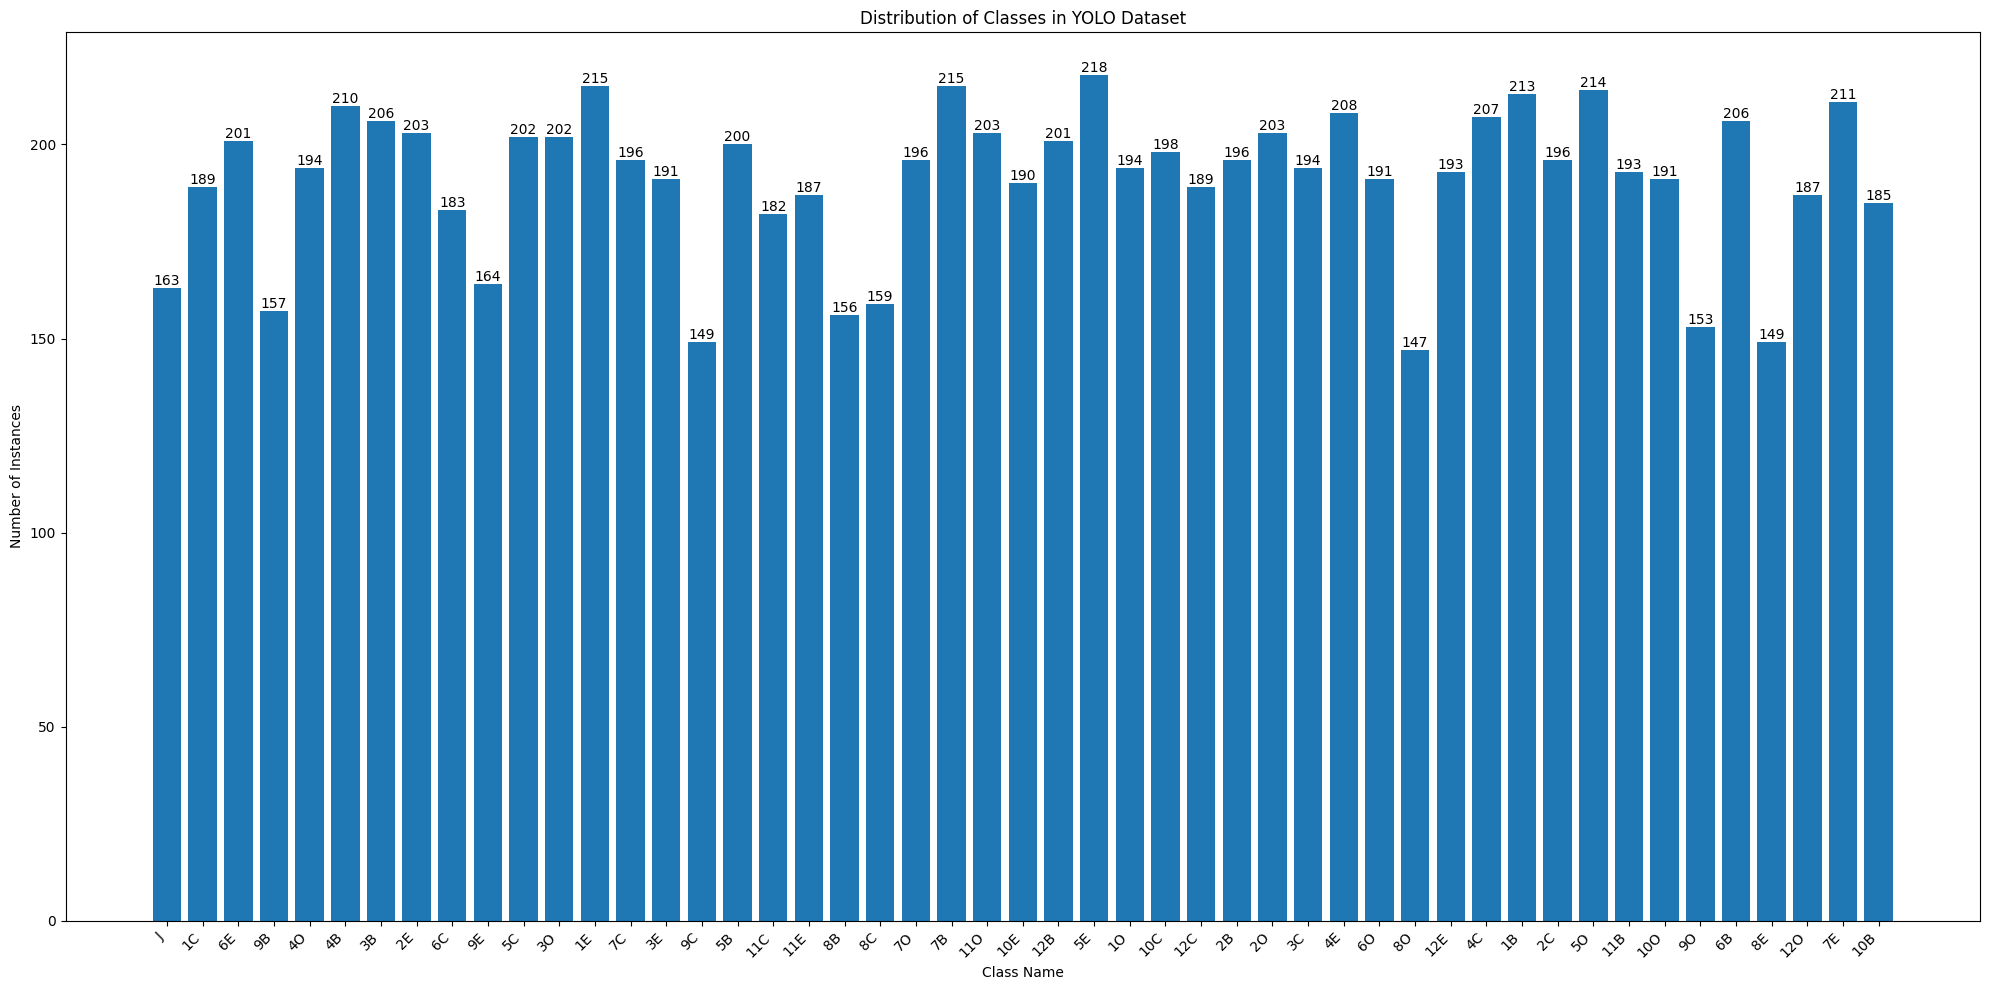

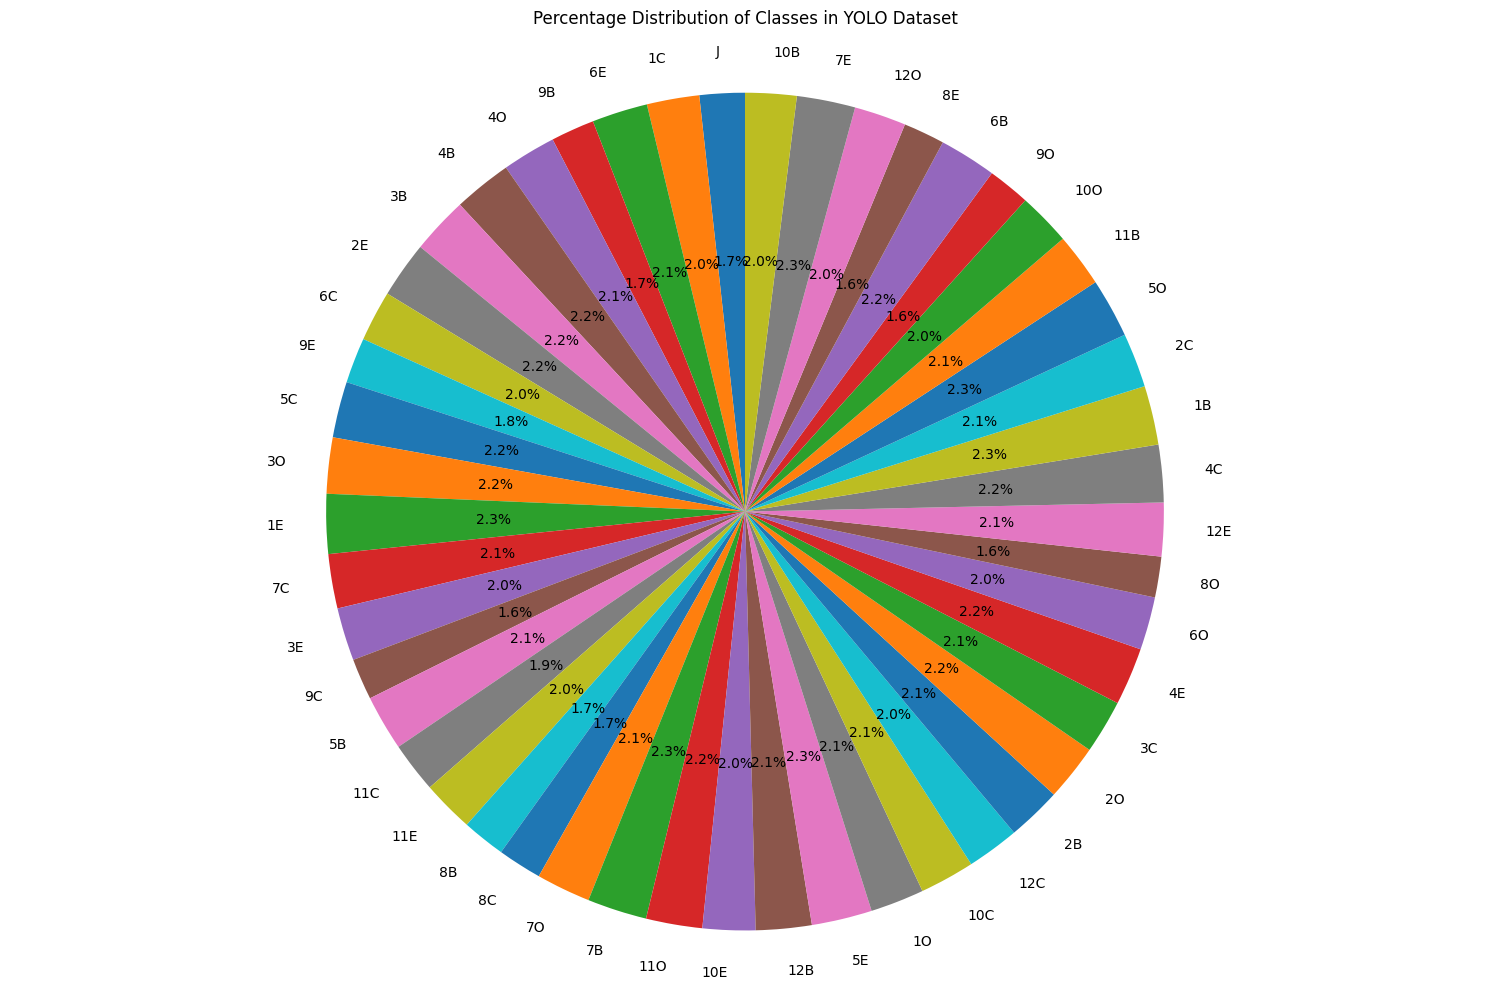

Total number of annotations: 9350
Number of classes: 49

Charts have been saved as 'class_distribution_bar.png' and 'class_distribution_pie.png'


In [58]:
# Definir nombres de clases
class_names = ['1O', '1C', '1E', '1B', '2O', '2C', '2E', '2B', '3O', '3C', '3E', '3B', '4O', '4C', '4E', '4B', 
               '5O', '5C', '5E', '5B', '6O', '6C', '6E', '6B', '7O', '7C', '7E', '7B', '8O', '8C', '8E', '8B', 
               '9O', '9C', '9E', '9B', '10O', '10C', '10E', '10B', '11O', '11C', '11E', '11B', '12O', '12C', '12E', '12B', 'J']

def analyze_dataset(dataset_path):
    class_counts = Counter()
    
    for filename in os.listdir(dataset_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(dataset_path, filename)
            
            with open(file_path, 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    class_counts[class_names[class_id]] += 1
    
    return class_counts

def plot_bar_chart(class_distribution):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())
    
    plt.figure(figsize=(20, 10))
    bars = plt.bar(classes, counts)
    plt.title('Distribución de Clases en el Dataset')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad de instancias')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('./Results/distribucion_clases_barras.png')
    plt.show()

def plot_pie_chart(class_distribution):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())
    
    plt.figure(figsize=(15, 10))
    plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
    plt.title('Distribución de porcentajes de Clases en el Dataset', pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('./Results/distribucion_clases_torta.png')
    plt.show()


# Especificar la ruta al dataset
dataset_path = './Data/Dataset/'

# Analizar el dataset
class_distribution = analyze_dataset(dataset_path)

# Crear, guardar y mostrar el gráfico de barras
plot_bar_chart(class_distribution)

# Crear, guardar y mostrar el gráfico de torta
plot_pie_chart(class_distribution)

# Print summary statistics
total_annotations = sum(class_distribution.values())
print(f"Número total de anotaciones: {total_annotations}")
print(f"Número total de clases: {len(class_distribution)}")

print("\nLas figuras fueron guardadas como 'distribucion_clases_barras.png' y 'distribucion_clases_torta.png' en la carpeta Results")

# 6. División del dataset en conjuntos de entrenamiento, validación y prueba

In [63]:
def split_dataset(dataset_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
    
    train_files, test_val_files = train_test_split(image_files, train_size=train_ratio, random_state=42)
    val_files, test_files = train_test_split(test_val_files, train_size=val_ratio/(val_ratio + test_ratio), random_state=42)
    
    return train_files, val_files, test_files

def create_split_directories(base_path):
    for split in ['train', 'val', 'test']:
        for content in ['images', 'labels']:
            os.makedirs(os.path.join(base_path, split, content), exist_ok=True)

def copy_files(files, src_dir, dst_dir):
    for file in tqdm(files, desc=f"Copying to {dst_dir}"):
        img_src = os.path.join(src_dir, file)
        label_src = os.path.join(src_dir, file.replace('.jpg', '.txt'))
        
        shutil.copy(img_src, os.path.join(dst_dir, 'images', file))
        shutil.copy(label_src, os.path.join(dst_dir, 'labels', file.replace('.jpg', '.txt')))

# Determinar rutas de los directorios
dataset_path = './Data/Dataset/'
output_path = './Data/Splitted_Dataset/'

# Dividir el dataset en partes
train_files, val_files, test_files = split_dataset(dataset_path)

# Crear directorios para los splits
create_split_directories(output_path)

# Copiar los archivos a los respectivos directorios
copy_files(train_files, dataset_path, os.path.join(output_path, 'train'))
copy_files(val_files, dataset_path, os.path.join(output_path, 'val'))
copy_files(test_files, dataset_path, os.path.join(output_path, 'test'))

print("Dataset splitting completed.")

Copying to ./Data/Splitted_Dataset/test: 100%|██████████| 230/230 [00:02<00:00, 77.65it/s]

Dataset splitting completed.


# 7. Aumentación del conjunto de entrenamiento

In [64]:
def apply_augmentations(image, bboxes):
    augmented_images = []
    augmented_bboxes = []

    # Imagen original
    augmented_images.append(image)
    augmented_bboxes.append(bboxes)

    # Inversión horizontal
    flipped_image = cv2.flip(image, 1)
    flipped_bboxes = []
    for bbox in bboxes:
        class_id, x, y, w, h = bbox
        flipped_bboxes.append([class_id, 1 - x, y, w, h])
    augmented_images.append(flipped_image)
    augmented_bboxes.append(flipped_bboxes)

    # Ajuste de brillo aleatorio
    brightness_image = cv2.convertScaleAbs(image, alpha=random.uniform(0.8, 1.2), beta=random.uniform(-30, 30))
    augmented_images.append(brightness_image)
    augmented_bboxes.append(bboxes)

    # Rotación aleatoria (Dentro de un pequeño margen)
    angle = random.uniform(-15, 15)
    height, width = image.shape[:2]
    M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (width, height))
    rotated_bboxes = []
    for bbox in bboxes:
        class_id, x, y, w, h = bbox
        # Ajustar las coordenadas de los bbox
        rotated_bboxes.append([class_id, x, y, w, h])
    augmented_images.append(rotated_image)
    augmented_bboxes.append(rotated_bboxes)

    return augmented_images, augmented_bboxes

def augment_dataset(train_dir):
    images_dir = os.path.join(train_dir, 'images')
    labels_dir = os.path.join(train_dir, 'labels')

    for image_file in tqdm(os.listdir(images_dir), desc="Aumentando imágenes"):
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        
        with open(label_path, 'r') as f:
            bboxes = [list(map(float, line.strip().split())) for line in f]

        augmented_images, augmented_bboxes = apply_augmentations(image, bboxes)

        for i, (aug_image, aug_bboxes) in enumerate(zip(augmented_images, augmented_bboxes)):
            if i == 0:  # Saltar la imagen original
                continue
            
            aug_image_file = f"{image_file.split('.')[0]}_aug_{i}.jpg"
            aug_label_file = f"{image_file.split('.')[0]}_aug_{i}.txt"
            
            cv2.imwrite(os.path.join(images_dir, aug_image_file), aug_image)
            
            with open(os.path.join(labels_dir, aug_label_file), 'w') as f:
                for bbox in aug_bboxes:
                    f.write(' '.join(map(str, bbox)) + '\n')


# Ejecutar la aumentación
train_dir = './Data/Splitted_Dataset/train/'
augment_dataset(train_dir)
print("Aumentación del dataset completada.")

Augmenting images:   0%|          | 0/1069 [00:00<?, ?it/s]

Augmenting images: 100%|██████████| 1069/1069 [11:28<00:00,  1.55it/s]

Dataset augmentation completed.


## Verificar cantidad de anotaciones luegos de la aumentación

In [8]:
# Contar anotaciones
def count_annotations(dataset_path):
    total_annotations = 0
    
    labels_path = os.path.join(dataset_path, 'labels')
    
    for filename in os.listdir(labels_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(labels_path, filename)
            
            with open(file_path, 'r') as f:
                for line in f:
                    try:
                        class_id = int(float(line.split()[0]))
                        
                        total_annotations += 1
                    except (ValueError, IndexError) as e:
                        print(f"Error processing file {filename}, line: {line.strip()}. Error: {str(e)}")
                        continue
    
    return total_annotations

# Definir ruta del dataset de train
dataset_path = './Data/Splitted_Dataset/train'

# Contar anotaciones
total_annotations = count_annotations(dataset_path)

# Imprimir la cantidad de anotaciones.
print(f"Cantidad de anotaciones en el dataset de entrenamiento después de la aumentación: {total_annotations}")

Cantidad de anotación después de la aumentación: 25920


# 8. Visualizar el dataset de entrenamiento

In [2]:
# Definir la ruta al dataset de entrenamiento
dataset_dir = "./Data/Splitted_Dataset/train"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")

# Definir los nombres de clases
class_names = ['1O', '1C', '1E', '1B', '2O', '2C', '2E', '2B', '3O', '3C', '3E', '3B', '4O', '4C', '4E', '4B', 
               '5O', '5C', '5E', '5B', '6O', '6C', '6E', '6B', '7O', '7C', '7E', '7B', '8O', '8C', '8E', '8B', 
               '9O', '9C', '9E', '9B', '10O', '10C', '10E', '10B', '11O', '11C', '11E', '11B', '12O', '12C', '12E', '12B', 'J']

# Crear el dataset de FiftyOne
dataset = fo.Dataset("YOLO Augmented Dataset_")

# Añadir las muestras al dataset
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(images_dir, filename)
        label_path = os.path.join(labels_dir, filename.replace(".jpg", ".txt"))
        
        sample = fo.Sample(filepath=image_path)
        
        # Parse YOLO format labels
        detections = []
        with open(label_path, "r") as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                detections.append(
                    fo.Detection(
                        label=class_names[int(class_id)],
                        bounding_box=[x_center - width/2, y_center - height/2, width, height]
                    )
                )
        
        sample["ground_truth"] = fo.Detections(detections=detections)
        dataset.add_sample(sample)

print(dataset)

# Visulaizar el dataset
session = fo.launch_app(dataset)
session.wait()

Migrating database to v0.24.1
Name:        YOLO Augmented Dataset_
Media type:  image
Num samples: 4276
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|

Notebook sessions cannot wait
